Solve the eigenvalue equation $Aq=\omega Bq$ for the Orr-Sommerfeld and Squire equations.

## Derivatives and matrix equations

In [34]:
import numpy as np
from scipy import linalg
from scipy.special import factorial
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
#%matplotlib inline
%matplotlib notebook
plt.style.use('seaborn-notebook')

def get_D_Coeffs(s,d=2):
    '''
    Solve arbitrary stencil points s of length N with order of derivatives d<N
    can be obtained from equation on MIT website
    http://web.media.mit.edu/~crtaylor/calculator.html
    where the accuracy is determined as the usual form O(h^(N-d))
    
    Inputs:
        s: array like input of stencil points e.g. np.array([-3,-2,-1,0,1])
        d: order of desired derivative
    '''
    # let's solve an Ax=b problem
    N=s.size # stencil length
    A=[]
    for i in range(N):
        A.append(s**i)
    b=np.zeros(N)
    b[d] = factorial(d)
    x = np.linalg.solve(np.matrix(A),b)
    return x
def set_D2(y,order=2):
    '''
    Input:
        y: array of y values of channel
    Output:
        D2: Second derivative of order O(h^2) or what specifide assuming uniform y spacing
    '''
    n = y.size
    h=y[1]-y[0]
    ones=np.ones(n)
    I=np.eye(n)
    if order==2:
        diag = -2. * ones
        diag_m1 = 1. * ones[:-1]
        diag_p1 = 1. * ones[:-1]
        D2 =  (
            np.diag(diag_p1,k=1) +
            np.diag(diag) + 
            np.diag(diag_m1,k=-1))
        return (1./(h**2)) * D2[1:-1,:] # do not return the top or bottom row
    else:
        # get coefficients for main diagonals
        d=2
        N=order+d # how many pts needed for order of accuracy
        if N>n:
            raise ValueError('You need more points in your domain, you need %i pts and you only gave %i'%(N,n))
        Nm1=N-1 # how many pts needed if using central difference is equal to N-1
        # stencil and get Coeffs for diagonals
        s = np.arange(Nm1)-(Nm1-1)/2 # stencil for central diff of order
        smax=s[-1] # right most stencil used (positive range)
        Coeffs = get_D_Coeffs(s,d=d)
        # loop over s and add coefficient matrices to D2
        D2 = np.zeros_like(I)
        si = np.nditer(s,('c_index',))
        while not si.finished:
            i = si.index
            if si[0]==0:
                diag_to_add = np.diag(Coeffs[i] * ones,k=si[0])
            else:
                diag_to_add = np.diag(Coeffs[i] * ones[:-abs(si[0])],k=si[0])
                
            D2 += diag_to_add
            si.iternext()
        # alter BC so we don't go out of range on bottom of channel
        for i in range(1,smax):
            # for ith row, set proper stencil coefficients
            s = np.arange(N)-i # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D2[i,:] = 0. # set row to zero
            D2[i,s+i] = Coeffs # set row to have proper coefficients
            
            # for -ith-1 row, set proper stencil coefficients
            s = -(np.arange(N)-i) # stencil for shifted diff of order
            print i,s
            Coeffs = get_D_Coeffs(s,d=d)
            D2[-i-1,:] = 0. # set row to zero
            D2[-i-1,s-i-1] = Coeffs # set row to have proper coefficients
        
        return (1./(h**2)) * D2[1:-1,:] # do not return the top or bottom row
def set_D4(y,order=2):
    '''
    Input:
        y: array of y values of channel
    Output:
        D4: Fourth derivative of order O(h^2) or what is specified assuming uniform y spacing and D1(y)=0 at walls
    '''
    h = y[1]-y[0] # uniform spacing
    n = y.size
    ones=np.ones(n)
    I = np.eye(n)
    if order==2:
        diag = 6. * np.diag(I)
        diag_m1 = -4. * np.diag(I)[:-1]
        diag_p1 = -4. * np.diag(I)[:-1]
        diag_m2 = 1. * np.diag(I)[:-2]
        diag_p2 = 1. * np.diag(I)[:-2]
        D4 = (
            np.diag(diag_p2,k=2) + 
            np.diag(diag_p1,k=1) + 
            np.diag(diag) + 
            np.diag(diag_m1,k=-1) + 
            np.diag(diag_m2,k=-2))
        # set second and second to last rows to be shifted one sided
        D4[1,:6] = [2,-9,16,-14,6,-1.]
        D4[-2,-6:] = [-1,6.,-14,16,-9,2]
        return (1./(h**4)) * D4[1:-1,:] # do not return the top or bottom rows
    else:
        # get coefficients for main diagonals
        d=4
        N=order+d # how many pts needed for order of accuracy
        if N>n:
            raise ValueError('You need more points in your domain, you need %i pts and you only gave %i'%(N,n))
        Nm1=N-1 # how many pts needed if using central difference is equal to N-1
        # stencil and get Coeffs for diagonals
        s = np.arange(Nm1)-(Nm1-1)/2 # stencil for central diff of order
        smax=s[-1] # right most stencil used (positive range)
        Coeffs = get_D_Coeffs(s,d=d)
        # loop over s and add coefficient matrices to D4
        D4 = np.zeros_like(I)
        si = np.nditer(s,('c_index',))
        while not si.finished:
            i = si.index
            if si[0]==0:
                diag_to_add = np.diag(Coeffs[i] * ones,k=si[0])
            else:
                diag_to_add = np.diag(Coeffs[i] * ones[:-abs(si[0])],k=si[0])
                
            D4 += diag_to_add
            si.iternext()
        # alter BC so we don't go out of range on bottom of channel
        for i in range(1,smax):
            # for ith row, set proper stencil coefficients
            s = np.arange(N)-i # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D4[i,:] = 0. # set row to zero
            D4[i,s+i] = Coeffs # set row to have proper coefficients
            
            # for -ith-1 row, set proper stencil coefficients
            s = -(np.arange(N)-i) # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D4[-i-1,:] = 0. # set row to zero
            D4[-i-1,s-i-1] = Coeffs # set row to have proper coefficients
        
        return (1./(h**4)) * D4[1:-1,:] # do not return the top or bottom row
def set_BCs(y,Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta,BCs='v vy eta Bfix'):
    h=y[1]-y[0]
    if BCs=='v vy eta':
        # v'=0 at walls
        # alter first and last line of Aos and Bos to contain v'=0 BC
        Aos[(0,-1),:] = 0.
        Bos[(0,-1),:] = 0.
        Aos[0,:3] = [-3.,4.,-1.]#/(2.*h)
        Aos[-1,-3:] = [1.,-4.,3.]#/(2.*h)
        # v=0 at walls
        # rows to add to Aos and Bos at top and bottom
        zero_row = np.zeros((1,Aos[0,:].size))
        v0_at_bottom = np.copy(zero_row)
        v0_at_bottom[0,0] = 1.
        v0_at_top = np.copy(zero_row)
        v0_at_top[0,-1] = 1.
        # add them to Aos and Bos
        Aos = np.concatenate((v0_at_bottom,Aos,v0_at_top),axis=0)
        Bos = np.concatenate((zero_row,Bos,zero_row),axis=0)
        # eta=0 at walls
        # rows to add to Asq_v, Bsq_v, Asq_eta, Bsq_eta
        Asq_v = np.concatenate((zero_row,Asq_v,zero_row),axis=0)
        Bsq_v = np.concatenate((zero_row,Bsq_v,zero_row),axis=0)
        eta_at_bottom = v0_at_bottom
        eta_at_top = v0_at_top
        Asq_eta = np.concatenate((eta_at_bottom,Asq_eta,eta_at_top),axis=0)
        Bsq_eta = np.concatenate((zero_row,Bsq_eta,zero_row),axis=0)
    elif BCs=='v vy eta Bfix':
        large_multiple=600.
        # v'=0 at walls
        # alter first and last line of Aos and Bos to contain v'=0 BC
        Aos[(0,-1),:] = 0.
        Bos[(0,-1),:] = 0.
        Aos[0,:3] = [-3.,4.,-1.]#/(2.*h)
        Bos[0,:3] = large_multiple*np.array([-3.,4.,-1.])#/(2.*h)
        Aos[-1,-3:] = [1.,-4.,3.]#/(2.*h)
        Bos[-1,-3:] = large_multiple*np.array([1.,-4.,3.])#/(2.*h)
        # v=0 at walls
        # rows to add to Aos and Bos at top and bottom
        zero_row = np.zeros((1,Aos[0,:].size))
        v0_at_bottom = np.copy(zero_row)
        v0_at_bottom[0,0] = 1.
        v0_at_top = np.copy(zero_row)
        v0_at_top[0,-1] = 1.
        # add them to Aos and Bos
        Aos = np.concatenate((v0_at_bottom,Aos,v0_at_top),axis=0)
        Bos = np.concatenate((large_multiple*v0_at_bottom,Bos,large_multiple*v0_at_top),axis=0)
        # eta=0 at walls
        # rows to add to Asq_v, Bsq_v, Asq_eta, Bsq_eta
        Asq_v = np.concatenate((zero_row,Asq_v,zero_row),axis=0)
        Bsq_v = np.concatenate((zero_row,Bsq_v,zero_row),axis=0)
        eta_at_bottom = v0_at_bottom
        eta_at_top = v0_at_top
        Asq_eta = np.concatenate((eta_at_bottom,Asq_eta,eta_at_top),axis=0)
        Bsq_eta = np.concatenate((large_multiple*eta_at_bottom,Bsq_eta,large_multiple*eta_at_top),axis=0)
    elif BCs=='vy eta alter v':
        # v=0 at walls
        # alter first and last line of Aos and Bos to contain v=0 BC
        Aos[0,0] = 0.
        Bos[-1,-1] = 0.
        # v'=0 at walls
        # rows to add to Aos and Bos at top and bottom
        zero_row = np.zeros((1,Aos[0,:].size))
        v0_at_bottom = np.copy(zero_row)
        v0_at_bottom[0,:3] = [-3.,4.,-1.]/(2.*h)
        v0_at_top = np.copy(zero_row)
        v0_at_top[-1,-3:] = [1.,-4.,3.]/(2.*h)
        # add them to Aos and Bos
        Aos = np.concatenate((v0_at_bottom,Aos,v0_at_top),axis=0)
        Bos = np.concatenate((zero_row,Bos,zero_row),axis=0)
        # eta=0 at walls
        # rows to add to Asq_v, Bsq_v, Asq_eta, Bsq_eta
        Asq_v = np.concatenate((zero_row,Asq_v,zero_row),axis=0)
        Bsq_v = np.concatenate((zero_row,Bsq_v,zero_row),axis=0)
        eta_at_bottom = np.copy(zero_row)
        eta_at_bottom[0] = 1.
        eta_at_top = np.copy(zero_row)
        eta_at_top[-1] = 1.
        Asq_eta = np.concatenate((eta_at_bottom,Asq_eta,eta_at_top),axis=0)
        Bsq_eta = np.concatenate((zero_row,Bsq_eta,zero_row),axis=0)
    elif BCs=='add eta v':
        # v=0 at walls
        # add first and last line of Aos and Bos to contain v=0 BC
        zero_row = np.zeros((1,Aos[0,:].size))
        # v'=0 at walls
        # rows to add to Aos and Bos at top and bottom
        v0_at_bottom = np.copy(zero_row)
        v0_at_bottom[0,:3] = [-3.,4.,-1.]/(2.*h)
        v0_at_top = np.copy(zero_row)
        v0_at_top[-1,-3:] = [1.,-4.,3.]/(2.*h)
        # add them to Aos and Bos
        Aos = np.concatenate((v0_at_bottom,Aos,v0_at_top),axis=0)
        Bos = np.concatenate((zero_row,Bos,zero_row),axis=0)
        # eta=0 at walls
        # rows to add to Asq_v, Bsq_v, Asq_eta, Bsq_eta
        Asq_v = np.concatenate((zero_row,Asq_v,zero_row),axis=0)
        Bsq_v = np.concatenate((zero_row,Bsq_v,zero_row),axis=0)
        eta_at_bottom = np.copy(zero_row)
        eta_at_bottom[0] = 1.
        eta_at_top = np.copy(zero_row)
        eta_at_top[-1] = 1.
        Asq_eta = np.concatenate((eta_at_bottom,Asq_eta,eta_at_top),axis=0)
        Bsq_eta = np.concatenate((zero_row,Bsq_eta,zero_row),axis=0)
    else:
        raise ValueError('Need to set BCs to "v vy eta" or "vy eta alter v" instead of : %s'%BCs)
    return (Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta)
def set_A_and_B(y,alpha=1,beta=0.,Re=2000.,compute='OSS',BCs='v vy eta Bfix',order=2):
    '''
    Set A and B matrix for stated eigenvalue equation Aq=\omega Bq
    Input:
        y: array of y values of channel
        alpha=1 : alpha value for eigenvalue equation for channel flow
        Re=2000. : Reynolds number for flow
        compute: which equations to compute Orr-Sommerfeld-Squire "OSS" or "OS" or "SQ"
        BCs:  which boundary conditions to use, use the default 
        order: order of accuracy of finite difference derivatives to use
    Output:
        A: matrix for LHS of eigenvalue equation
        B: matrix for RHS of eigenvalue equation
    '''
    #h=y[1]-y[0] # uniform spacing is assumed
    k2=alpha**2 + beta**2
    ialpha=1.j * alpha
    
    # identity matrix
    I = np.eye(y.size)
    # base flow
    U = 1.-y[1:-1,np.newaxis]**2 # make a n vector of shape (n,1) so U will broadcast with D2 and D4 correctly
    Uy = -2.*y[1:-1,np.newaxis] # dU/dy of base flow
    Uyy = -2. # d^2 U/dy^2 of base flow
    
    # calculate derivatives
    D2 = set_D2(y,order=order)
    D4 = set_D4(y,order=order)
    
    # for Orr-Sommerfeld eq.
    # set aA and bA constants for each y
    aA = (ialpha*Re*(U*(-k2)-Uyy)-k2**2)
    bA = (ialpha*Re*U+2.*k2)
    # set aB and bB constants for each y
    aB = -1.j*Re*k2
    bB = 1.j*Re
    # create Aos, Bos
    Aos = -D4 + bA*D2 + aA*I[1:-1,:]
    Bos =       bB*D2 + aB*I[1:-1,:]
    
    # for Squire eq.
    # set cA,dA, and fA constants for each y
    cA = (ialpha*Re*U + k2 )
    dA = (-1.              )
    fA = (1.j*beta*Re*Uy   )
    # set cB constant for each y
    cB = (1.j*Re           )
    # create eta Asq,Bsq 
    Asq_eta = dA*D2 + cA*I[1:-1,:]
    Bsq_eta =         cB*I[1:-1,:]
    # create v Asq,Bsq
    Asq_v = fA*I[1:-1,:] # cut top and bottom of I
    Bsq_v = 0.*I[1:-1,:]
    
    # BCs
    Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta = set_BCs(y,Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta,BCs=BCs)
    
    #combine to A and B for combined eqs.
    if compute=='OSS':
        A = np.concatenate((
                np.concatenate((Aos, 0.*I),axis=1), # Orr-Sommerfeld
                np.concatenate((Asq_v,Asq_eta),axis=1)) # Squire
            ,axis=0)
        B = np.concatenate((
                np.concatenate((Bos, 0.*I),axis=1), # Orr-Sommerfeld
                np.concatenate((Bsq_v,Bsq_eta),axis=1)) # Squire
            ,axis=0)
    # if just Orr-Sommerfeld
    elif compute=='OS':
        A = Aos
        B = Bos
    elif compute=='SQ':
        A = Asq_eta
        B = Bsq_eta
    else :
        raise ValueError('compute needs to be OSS or OS instead of : %s'%compute)
        return 0
    
    return (A,B)
def set_and_solve_eig(n=201,alpha=1.,beta=0.,Re=10000.,compute='OSS',BCs='v vy eta Bfix',order=2):
    '''
    Inputs:
        n=201:                    number of pts in spatial y for finite difference scheme
        alpha=1.:                 alpha in Orr-Sommerfeld and Squire equations
        beta=0.:                  beta in Orr-Sommerfeld and Squire equations
        Re=10000.:                Reynolds number
        compute='OSS':            ["OS","OSS","SQ"] choice of solving for Orr-Sommerfeld alone or for Orr-Sommerfeld-Squire or Squire with beta=0
        BCs='v vy eta Bfix'       Which Boundary Condition should we implement
            Choices:
                'v vy eta':       First attempt
                'v vy eta Bfix':  This is the current one.  Use this one
                'vy eta alter v': Second attempt
                'add eta v':      Third attempt
        order: order of accuracy of finite difference derivatives to use
    Returns:
        eig:     eigenvalues of the equation
        evec:    eigenvectors of the equation
        eig_i:   index for eig and evec for max(eig) to smallest(eig) by using np.sort()
    '''
    print 'inputs:'
    print '    n=%i,  alpha=%.1f, beta=%.1f, Re=%.1e, compute=%s, BCs=%s'%(n,alpha,beta,Re,compute,BCs)
    
    # create y
    y = np.linspace(-1,1,n)
    # solve eigenvalue problem
    A,B = set_A_and_B(y,alpha=alpha,beta=beta,Re=Re,compute=compute,BCs=BCs,order=order)
    eig,evec = linalg.eig(A,b=B)
    
    # sort in order of decending eigenvalues using argsort and print max,min,nans,inf
    eig_i = eig.argsort()[::-1]   
    print 'check max and min eig'
    print '   ',eig[np.argmax(np.abs(eig))]
    print '   ',eig[np.argmin(np.abs(eig))]
    print 'check isnan and isinf'
    print '   ',eig[np.isnan(eig)]
    print '   ',eig[np.isinf(eig)]
    
    # check BCs
    print 'check BCs v=v_y=eta=0'
    # check values at walls
    BadBCvn1 = evec[0,:]!=0
    BadBCvp1 = evec[n-1,:]!=0
    if compute=='OSS':
        BadBCetan1 = evec[n,:]!=0
        BadBCetap1 = evec[-1,:]!=0

    print '  bad boundary condition eigenfunctions satisfying v=0'
    print '   ',evec[0,BadBCvn1],'with associated eig-value of',eig[BadBCvn1],' v(y=-1 )=0'
    print '   ',evec[n-1,BadBCvp1],'with associated eig-value of',eig[BadBCvp1],' v(y=1 )=0'
    if compute=='OSS':
        print '  bad boundary condition eigenfunctions satisfying eta=0'
        BadBCetan1 = evec[n,:]!=0
        BadBCetap1 = evec[-1,:]!=0
        print '   ',evec[n,BadBCetan1],'with associated eig-value of',eig[BadBCetan1],' eta(y=-1)=0'
        print '   ',evec[-1,BadBCetap1],'with associated eig-value of',eig[BadBCetap1],' eta(y=1 )=0'
    # now check v'
    vy_bot = -3.*evec[0,:] + 4.*evec[1,:] - evec[2,:]
    # which ones are orr-sommerfeld and which are squire?
    # now v'=0 at other wall
    vy_top = 1.*evec[n-3,:] -4.*evec[n-2,:] + 3.*evec[n-1,:]

    # plot derivative at walls for every eigenfunction for v=0
    fig=plt.figure(figsize=(5,4))
    plt.title('dv/dy=0 at wall check')
    plt.plot(vy_bot[eig_i],'.',label='bot')
    plt.plot(vy_top[eig_i],'.',label='top')
    plt.ylabel(r'$\frac{d\hat{v}}{dy}(y=\pm 1)$')
    plt.xlabel(r'$\omega_{max}$ to $\omega_{min}$')
    plt.legend(loc='best',numpoints=1,frameon=False)
    plt.tight_layout()
    
    # plot Orr-Sommerfeld spectrum
    fig=plt.figure(figsize=(4,4))
    ax=plt.subplot(111)
    ax.plot(eig.real,eig.imag,'bo')
    ax.set_xlabel(r'$\omega_r$')
    ax.set_ylabel(r'$\omega_i$')
    ax.axis([0,1,-1.,0])
    ax.set_title('eigenvalues')
    plt.tight_layout()
    #ax.legend(loc='best',numpoints=1,frameon=False)
    
    plt.show()
    return eig,evec,eig_i



inputs:
    n=151,  alpha=1.0, beta=0.0, Re=1.0e+04, compute=OSS, BCs=v vy eta Bfix
1 [ 1  0 -1 -2 -3 -4]
check max and min eig
    (0.990889072814-2.99097128638j)
    (0.00166666666667+0j)
check isnan and isinf
    []
    []
check BCs v=v_y=eta=0
  bad boundary condition eigenfunctions satisfying v=0
    [ 0.06300262+0.j] with associated eig-value of [ 0.00166667+0.j]  v(y=-1 )=0
    [ 0.04742719+0.j] with associated eig-value of [ 0.00166667+0.j]  v(y=1 )=0
  bad boundary condition eigenfunctions satisfying eta=0
    [ 0.65277977+0.j] with associated eig-value of [ 0.00166667+0.j]  eta(y=-1)=0
    [ 0.65277977+0.j] with associated eig-value of [ 0.00166667+0.j]  eta(y=1 )=0


<IPython.core.display.Javascript object>


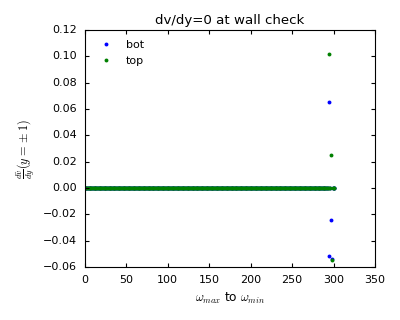

<IPython.core.display.Javascript object>


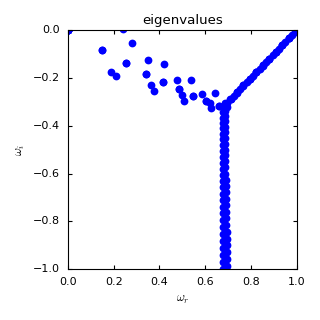

In [35]:
eig,evec,eig_i = set_and_solve_eig(n=151,alpha=1.,beta=0.,Re=10000.,compute='OSS',order=4)

inputs:
    n=151,  alpha=0.0, beta=1.0, Re=1.0e+04, compute=OS, BCs=v vy eta Bfix
1 [ 1  0 -1 -2 -3 -4]
check max and min eig
    (-8.72865160892e-17-2.81222246936j)
    (-1.82961112573e-10-0.000931468983071j)
check isnan and isinf
    []
    []
check BCs v=v_y=eta=0
  bad boundary condition eigenfunctions satisfying v=0
    [ 0.32641255+0.j] with associated eig-value of [ 0.00166667+0.j]  v(y=-1 )=0
    [ 0.30751324+0.j] with associated eig-value of [ 0.00166667+0.j]  v(y=1 )=0


<IPython.core.display.Javascript object>


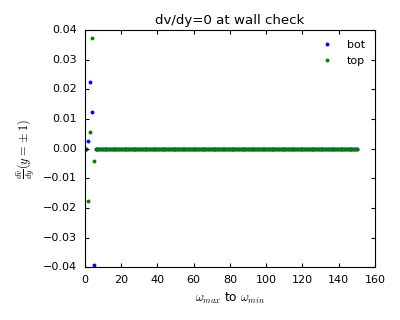

<IPython.core.display.Javascript object>


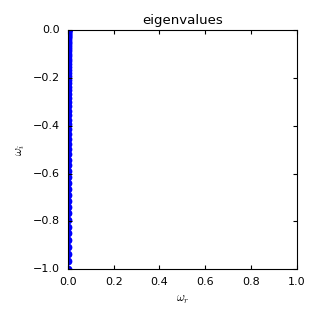

In [36]:
eig,evec,eig_i = set_and_solve_eig(n=151,alpha=0.,beta=1.,Re=10000.,compute='OS',order=4)

inputs:
    n=151,  alpha=1.0, beta=1.0, Re=5.0e+03, compute=OSS, BCs=v vy eta Bfix
1 [ 1  0 -1 -2 -3 -4]
check max and min eig
    (0.987107836351-5.98749005245j)
    (0.00166666666646-2.92036493108e-13j)
check isnan and isinf
    []
    []
check BCs v=v_y=eta=0
  bad boundary condition eigenfunctions satisfying v=0
    [ 0.00453486+0.j] with associated eig-value of [ 0.00166667+0.j]  v(y=-1 )=0
    [ 0.01555179+0.j] with associated eig-value of [ 0.00166667+0.j]  v(y=1 )=0
  bad boundary condition eigenfunctions satisfying eta=0
    [ 0.59671617+0.j] with associated eig-value of [ 0.00166667+0.j]  eta(y=-1)=0
    [ 0.59671617+0.j] with associated eig-value of [ 0.00166667+0.j]  eta(y=1 )=0


<IPython.core.display.Javascript object>


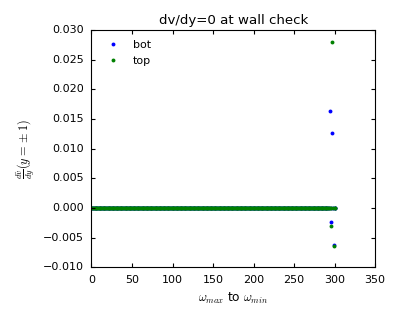

<IPython.core.display.Javascript object>


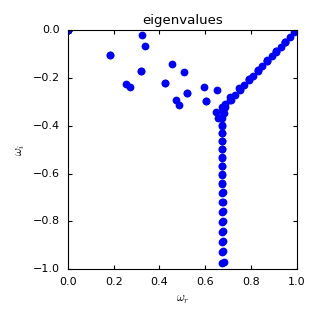

In [37]:
n=151
y=np.linspace(-1,1,n)
compute='OSS'
eig,evec,eig_i = set_and_solve_eig(n=n,alpha=1.,beta=1.,Re=5000.,compute=compute,order=4)

### plot A, P, and S branches

<IPython.core.display.Javascript object>


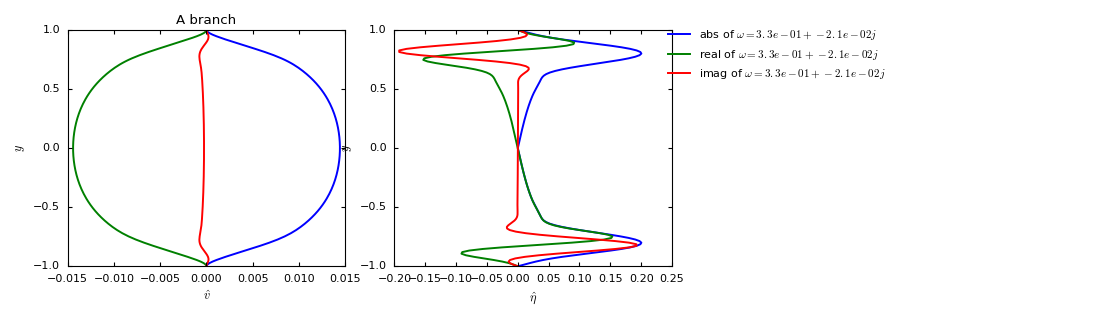

<IPython.core.display.Javascript object>


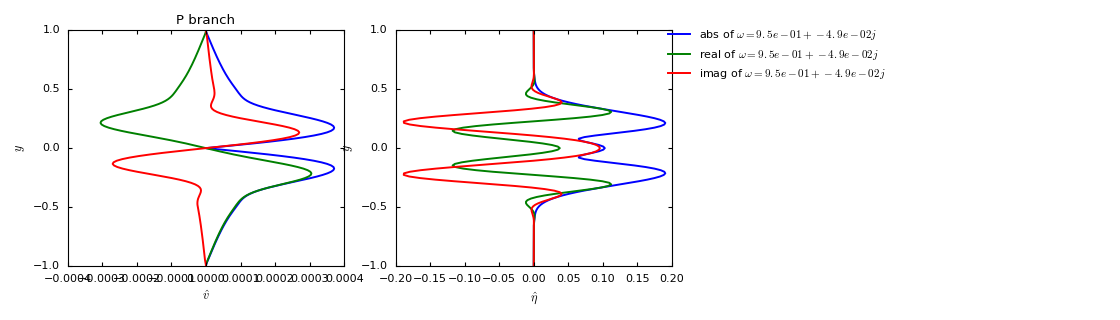

<IPython.core.display.Javascript object>


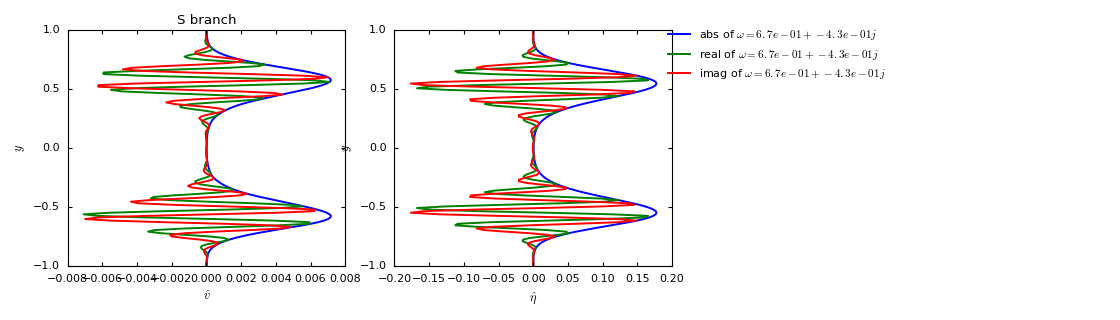

In [38]:
#eig_A_i = (eig.real>0.2) & (eig.real<0.6) & (eig.imag>-0.4) & (eig.imag<0.)
#eig_P_i = (eig.real>0.8) & (eig.real<1.0) & (eig.imag>-0.4) & (eig.imag<0.)
#eig_S_i = (eig.real>0.6) & (eig.real<0.8) & (eig.imag>-0.8) & (eig.imag<-0.5)
eig_A_i = (np.abs(eig-(0.3256-0.023j))).argmin()
#eig_A_i = (np.abs(eig-(0.31-0.265j))).argmin()
eig_P_i = (np.abs(eig-(0.95006-0.049325j))).argmin()
#eig_P_i = (np.abs(eig-(0.97-0.03j))).argmin()
#eig_P_i = (np.abs(eig-(0.99-0.01j))).argmin()
#eig_S_i = (np.abs(eig-(0.67165-0.5154j))).argmin()
eig_S_i = (np.abs(eig-(0.675-0.4190j))).argmin()

#eig_S_i = (np.abs(eig-(0.6735-0.458))).argmin()
# A,P, and S branches
fig=plt.figure(figsize=(14,4))
ax=plt.subplot(121)
ax2=plt.subplot(122)
ax.set_title('A branch')
ax.plot(
    np.abs(evec[:n,eig_A_i]),
    y,
    label=r'abs of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
ax.plot(
    evec[:n,eig_A_i].real,
    y,
    label=r'real of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
ax.plot(
    evec[:n,eig_A_i].imag,
    y,
    label=r'imag of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
ax2.plot( 
    np.abs(evec[n:,eig_A_i]),
    y,
    label=r'abs of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
ax2.plot( 
    evec[n:,eig_A_i].real,
    y,
    label=r'real of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
ax2.plot( 
    evec[n:,eig_A_i].imag,
    y,
    label=r'imag of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
ax.set_xlabel(r'$\hat{v}$')
ax.set_ylabel(r'$y$')
ax2.set_xlabel(r'$\hat{\eta}$')
ax2.set_ylabel(r'$y$')
ax2.legend(loc='upper left',frameon=False,numpoints=1,bbox_to_anchor=(0.95,1.05),)
fig.tight_layout()
plt.subplots_adjust(left=None, right=0.6, top=None, bottom=None)
    
fig=plt.figure(figsize=(14,4))
ax=plt.subplot(121)
ax2=plt.subplot(122)
ax.set_title('P branch')
ax.plot(
    np.abs(evec[:n,eig_P_i]),
    y,
    label=r'abs of $\omega = %.1e+%.1ej$'%(eig[eig_P_i].real,eig[eig_P_i].imag))
ax.plot(
    evec[:n,eig_P_i].real,
    y,
    label=r'real of $\omega = %.1e+%.1ej$'%(eig[eig_P_i].real,eig[eig_P_i].imag))
ax.plot(
    evec[:n,eig_P_i].imag,
    y,
    label=r'imag of $\omega = %.1e+%.1ej$'%(eig[eig_P_i].real,eig[eig_P_i].imag))
if compute=='OSS':
    ax2.plot(
        np.abs(evec[n:,eig_P_i]),
        y,
        label=r'abs of $\omega = %.1e+%.1ej$'%(eig[eig_P_i].real,eig[eig_P_i].imag))
    ax2.plot(
        evec[n:,eig_P_i].real,
        y,
        label=r'real of $\omega = %.1e+%.1ej$'%(eig[eig_P_i].real,eig[eig_P_i].imag))
    ax2.plot(
        evec[n:,eig_P_i].imag,
        y,
        label=r'imag of $\omega = %.1e+%.1ej$'%(eig[eig_P_i].real,eig[eig_P_i].imag))
ax.set_xlabel(r'$\hat{v}$')
ax.set_ylabel(r'$y$')
ax2.set_xlabel(r'$\hat{\eta}$')
ax2.set_ylabel(r'$y$')
ax2.legend(loc='upper left',frameon=False,numpoints=1,bbox_to_anchor=(0.95,1.05),)
fig.tight_layout()
plt.subplots_adjust(left=None, right=0.6, top=None, bottom=None)

fig=plt.figure(figsize=(14,4))
ax=plt.subplot(121)
ax2=plt.subplot(122)
ax.set_title('S branch')
ax.plot(
    np.abs(evec[:n,eig_S_i]),
    y,
    label=r'abs of $\omega = %.1e+%.1ej$'%(eig[eig_S_i].real,eig[eig_S_i].imag))
ax.plot(
    evec[:n,eig_S_i].real,
    y,
    label=r'real of $\omega = %.1e+%.1ej$'%(eig[eig_S_i].real,eig[eig_S_i].imag))
ax.plot(
    evec[:n,eig_S_i].imag,
    y,
    label=r'imag of $\omega = %.1e+%.1ej$'%(eig[eig_S_i].real,eig[eig_S_i].imag))
if compute=='OSS':
    ax2.plot(
        np.abs(evec[n:,eig_S_i]),
        y,
        label=r'abs of $\omega = %.1e+%.1ej$'%(eig[eig_S_i].real,eig[eig_S_i].imag))
    ax2.plot(
        evec[n:,eig_S_i].real,
        y,
        label=r'real of $\omega = %.1e+%.1ej$'%(eig[eig_S_i].real,eig[eig_S_i].imag))
    ax2.plot(
        evec[n:,eig_S_i].imag,
        y,
        label=r'imag of $\omega = %.1e+%.1ej$'%(eig[eig_S_i].real,eig[eig_S_i].imag))
ax.set_xlabel(r'$\hat{v}$')
ax.set_ylabel(r'$y$')
ax2.set_xlabel(r'$\hat{\eta}$')
ax2.set_ylabel(r'$y$')
ax2.legend(loc='upper left',frameon=False,numpoints=1,bbox_to_anchor=(0.95,1.05),)
fig.tight_layout()
plt.subplots_adjust(left=None, right=0.6, top=None, bottom=None)

plt.show()

### Compare in Plane Poiseuille to Schmid table for $\alpha=1, \beta=0, Re=2000$

In [39]:
#print eig[eig_i][6:27]
cos=np.array([
    0.31210030-0.01979866j,
    0.42418427-0.07671992j,
    0.92078667-0.07804706j,
    0.92091806-0.07820060j,
    0.85717055-0.13990151j,
    0.85758968-0.14031674j,
    0.79399812-0.20190508j,
    0.79413424-0.20232063j,
    0.63912513-0.22134137j,
    0.53442105-0.22356175j,
])
csq=np.array([
    0.98418861-0.01631139j,
    0.95256584-0.04793417j,
    0.92094306-0.07955694j,
    0.88932028-0.11117972j,
    0.24936056-0.13725811j,
    0.24936056-0.13725811j,
    0.85769752-0.14280249j,
    0.82607494-0.17442537j,
    0.79445264-0.20605114j,
    0.42863639-0.22466515j,
])
# combine Schmid
c=np.concatenate((cos,csq))
c_i = c.imag.argsort()[::-1]
RSSE_n=[]
n_all=[51,61,71,81,91,101,151,201,401]
iplot=False
for n in n_all:
    y=np.linspace(-1,1,n)
    compute='OSS'
    # solve eigenvalue problem
    A,B = set_A_and_B(y,alpha=1.,beta=0.,Re=2000.,compute='OSS',order=4)
    eig,evec = linalg.eig(A,b=B)
    # reorder in complex values first
    eig_i = eig.imag.argsort()[::-1]   

    # plot against table
    if iplot:
        fig=plt.figure() 
        ax=plt.subplot(111)
        ax.plot(cos.real,cos.imag,'s',label='cos Schmid')
        ax.plot(csq.real,csq.imag,'s',label='csq Schmid')
        ax.plot(eig[eig_i][6:27].real,eig[eig_i][6:27].imag,'.',label='Finit Difference')
        ax.set_xlabel(r'$\omega_r$')
        ax.set_ylabel(r'$\omega_i$')
        #ax.axis([0,1,-1.,0])
        ax.legend(loc='best',numpoints=1)
        fig.tight_layout()
        plt.show()

    # calc error as root sum squared
    RSSE=0
    for ci in c:
        min_error = ((np.abs(np.abs(eig[eig_i][6:27])-np.abs(ci))).min())**2 # minimum square value
        RSSE+=min_error # sum
    RSSE=np.sqrt(RSSE) # root
    RSSE_n.append(RSSE)

    print 'for n = %i then RMSE = %.3e'%(n,RSSE)

1 [ 1  0 -1 -2 -3 -4]
for n = 51 then RMSE = 1.026e-01
1 [ 1  0 -1 -2 -3 -4]
for n = 61 then RMSE = 1.011e-01
1 [ 1  0 -1 -2 -3 -4]
for n = 71 then RMSE = 1.207e-02
1 [ 1  0 -1 -2 -3 -4]
for n = 81 then RMSE = 1.030e-02
1 [ 1  0 -1 -2 -3 -4]
for n = 91 then RMSE = 8.720e-03
1 [ 1  0 -1 -2 -3 -4]
for n = 101 then RMSE = 7.363e-03
1 [ 1  0 -1 -2 -3 -4]
for n = 151 then RMSE = 3.539e-03
1 [ 1  0 -1 -2 -3 -4]
for n = 201 then RMSE = 2.042e-03
1 [ 1  0 -1 -2 -3 -4]
for n = 401 then RMSE = 5.265e-04


<IPython.core.display.Javascript object>


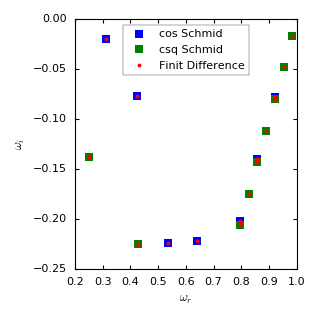

<IPython.core.display.Javascript object>


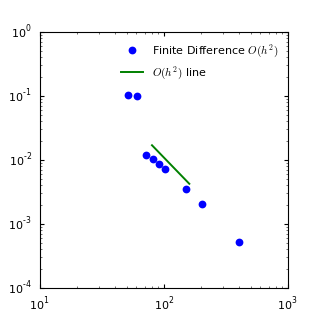

In [40]:
# plot eigenvalues
fig=plt.figure(figsize=(4,4)) 
ax=plt.subplot(111)
ax.plot(cos.real,cos.imag,'s',label='cos Schmid')
ax.plot(csq.real,csq.imag,'s',label='csq Schmid')
ax.plot(eig[eig_i][6:27].real,eig[eig_i][6:27].imag,'.',label='Finit Difference')
ax.set_xlabel(r'$\omega_r$')
ax.set_ylabel(r'$\omega_i$')
ax.legend(loc='best',numpoints=1)
fig.tight_layout()
# plot error convergence
fig=plt.figure(figsize=(4,4)) 
ax=plt.subplot(111)
ax.loglog(n_all,RSSE_n,'o',label=r'Finite Difference $O(h^2)$')
ax.loglog([80,160],[0.017,0.017/4.],label=r'$O(h^2)$ line')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$RSSE$')
ax.legend(loc='best',numpoints=1,frameon=False)
plt.show()

In [28]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [ ]:
x1=np.ones(4)
xi = np.nditer(x1,('c_index',))
while not xi.finished:
    print xi[0],xi.index
    xi.iternext()
    


In [3]:
help(set_D2)

Help on function set_D2 in module __main__:

set_D2(y, order=2)
    Input:
        y: array of y values of channel
    Output:
        D2: Second derivative of order O(h^2) assuming uniform y spacing

